In [ ]:
image_id1 = 911
image_id2 = 105
image_id3 = 1395
image_id4 = 1120
image_id5 = 1390
image_id6 = 689
image_id7 = 1264
image_id8 = 662

In [1]:
file_name = {
    "file_name1" : "0047.jpg",
    "file_name2" : "0200.jpg",
    "file_name3" : "00303.jpg",
    "file_name4" : "22-203.jpg",      
    "file_name5" : "764-11.jpg",
    "file_name6" : "00080.jpg",
    "file_name7" : "00269.jpg",
    "file_name8" : "001142.jpg"}

In [43]:
from pathlib import Path
from PIL import Image
import numpy as np
import torch
from panopticapi.utils import rgb2id
from util.box_ops import masks_to_boxes
import json

# "/home/reuben/Atom360/Learning/data/dataset/images" 
coco_path = "/home/wenisch/Atom360/AI/Learning/data/dataset/images"
coco_panoptic_path = "panoptic/"
idx = 662

In [44]:
image_set='train'

img_folder_root = Path(coco_path)
ann_folder_root = Path(coco_panoptic_path)
assert img_folder_root.exists(), f'provided COCO path {img_folder_root} does not exist'
assert ann_folder_root.exists(), f'provided COCO path {ann_folder_root} does not exist'
mode = 'panoptic'   
PATHS = {
        "train": ("train2017", Path("annotations") / f'{mode}_train2017.json'),
        "val": ("val2017", Path("annotations") / f'{mode}_val2017.json'),
    }

img_folder, ann_file = PATHS[image_set]
img_folder_path = img_folder_root #/ img_folder
ann_folder = ann_folder_root / f'{mode}_{img_folder}'
ann_file = ann_folder_root / ann_file

In [45]:
with open(ann_file, 'r') as f:
    coco_ann = json.load(f)
ann_info = coco_ann['annotations'][idx] if "annotations" in coco_ann else coco_ann['images'][idx]
img_path = Path(img_folder_path) / ann_info['file_name'].replace('.png', '.jpg')
ann_path = Path(ann_folder) / ann_info['file_name']
img = Image.open(img_path).convert('RGB')
w, h = img.size
if "segments_info" in ann_info:
    print("seg info present")
    masks = np.asarray(Image.open(ann_path), dtype=np.uint32)
    masks = rgb2id(masks)
    ids = np.array([ann['id'] for ann in ann_info['segments_info']])
    masks = masks == ids[:, None, None]
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    # labels = torch.tensor([ann['category_id'] for ann in ann_info['segments_info']], dtype=torch.int64
target = {}
target['image_id'] = torch.tensor([ann_info['image_id'] if "image_id" in ann_info else ann_info["id"]])
# if self.return_masks:
target['masks'] = masks
# target['labels'] = label
# target["boxes"] = masks_to_boxes(target['masks'])

seg info present


In [64]:
def masks_to_boxes_final(masks: torch.Tensor) -> torch.Tensor:
    """
    Compute the bounding boxes around the provided masks.

    Returns a [N, 4] tensor containing bounding boxes. The boxes are in ``(x1, y1, x2, y2)`` format with
    ``0 <= x1 < x2`` and ``0 <= y1 < y2``.

    Args:
        masks (Tensor[N, H, W]): masks to transform where N is the number of masks
            and (H, W) are the spatial dimensions.

    Returns:
        Tensor[N, 4]: bounding boxes
    """
    if masks.numel() == 0:
        return torch.zeros((0, 4), device=masks.device, dtype=torch.float)

    n = masks.shape[0]

    bounding_boxes = torch.zeros((n, 4), device=masks.device, dtype=torch.float)

    for index, mask in enumerate(masks):
        y, x = torch.where(mask != 0)
        # print("len(x)", len(x))
        # print("len(y)", len(y))
        if len(x) ==0 and len(y) == 0:
            # print("continue")
            continue
        bounding_boxes[index, 0] = torch.min(x)
        bounding_boxes[index, 1] = torch.min(y)
        bounding_boxes[index, 2] = torch.max(x)
        bounding_boxes[index, 3] = torch.max(y)

    return bounding_boxes

In [65]:
target["boxes"] = masks_to_boxes_final(target['masks'])
target["boxes"]

len(x) 1208687
len(y) 1208687
len(x) 0
len(y) 0
continue


tensor([[   0.,    0., 1279.,  959.],
        [   0.,    0.,    0.,    0.]])

In [90]:
import matplotlib.pyplot as plt
print(ann_path)
masks = np.asarray(Image.open(ann_path), dtype=np.uint32)
masks = rgb2id(masks)
ids = np.array([ann['id'] for ann in ann_info['segments_info']])
print(ids)
np.unique(masks)

panoptic/panoptic_train2017/1052-4.jpg
[11423049  3937500]


array([    2815,   133631,   660971, ..., 14434893, 14501697, 15092534],
      dtype=uint32)

In [ ]:

masks = masks == ids[:, None, None]
masks[1]

CLASSES [    2815   133631   660971 ... 14434893 14501697 15092534]
[11423049  3937500]


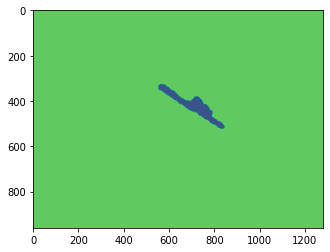

In [67]:
import matplotlib.pyplot as plt

masks = np.asarray(Image.open(ann_path), dtype=np.uint32)
masks = rgb2id(masks)
print("CLASSES", np.unique(masks))
print(np.array([ann['id'] for ann in ann_info['segments_info']]))
plt.imshow(masks)

In [9]:
masks.shape

(764, 1194)

In [7]:
type(masks)

numpy.ndarray

In [11]:

plt.imshow(masks)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)